In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
library(bigrquery)
set_service_token("p1rcc-coral-aa5ea14a2341.json")
con <- dbConnect(
  bigrquery::bigquery(),
  project = "p1rcc-coral",
  dataset = "somatic",
  billing = "p1rcc-coral"
)
dbListTables(con)

[1] "indels_snpeff"                  "indels_snpeff_with_gene"       
 [3] "snps_x_tcgas"                   "snvfiltered"                   
 [5] "snvs"                           "snvs_TCGA_overlap_Bill_SNPs"   
 [7] "snvs_snpeff_pass"               "snvs_snpeff_pass_with_gene_ann"
 [9] "tcgachr22"                      "tcgasnvchr22"

In [6]:
# -- Look for somatic mutations in patient's tumor that are in TCGA
sql_common_snps = "SELECT project_short_name,tcgas.case_barcode, tcgas.symbol, tcgas.sample_barcode_tumor, tcgas.IMPACT, tcgas.polyphen, tcgas.consequence, tcgas.variant_classification
FROM [p1rcc-coral:somatic.snvs_snpeff_pass_with_gene_ann] s
INNER JOIN [isb-cgc:TCGA_hg19_data_v0.Somatic_Mutation_MC3] tcgas on s.gene = tcgas.gene and s.end_position = tcgas.end_position
WHERE tcgas.variant_type = 'SNP'"
common_snps = query_exec(sql_common_snps, project = "p1rcc-coral", useLegacySql = FALSE)
head(common_snps)

0 bytes processed


project_short_name,tcgas_case_barcode,tcgas_symbol,tcgas_sample_barcode_tumor,tcgas_IMPACT,tcgas_polyphen,tcgas_consequence,tcgas_variant_classification
TCGA-SKCM,TCGA-FS-A1ZQ,SIRPB2,TCGA-FS-A1ZQ-06A,MODIFIER,NA,3_prime_UTR_variant,3'UTR
TCGA-UCEC,TCGA-AX-A05W,NUFIP2,TCGA-AX-A05W-01A,LOW,NA,synonymous_variant,Silent
TCGA-CESC,TCGA-EK-A2RK,SMARCC1,TCGA-EK-A2RK-01A,MODIFIER,NA,3_prime_UTR_variant,3'UTR
TCGA-UCEC,TCGA-A5-A2K3,PAX3,TCGA-A5-A2K3-01A,MODIFIER,NA,3_prime_UTR_variant,3'UTR
TCGA-UCEC,TCGA-AX-A2HD,KCTD3,TCGA-AX-A2HD-01A,LOW,NA,synonymous_variant,Silent
TCGA-SKCM,TCGA-EE-A2GO,DSC3,TCGA-EE-A2GO-06A,LOW,NA,synonymous_variant,Silent


In [7]:
common_snps$project_short_name = factor(common_snps$project_short_name, levels=rev(names(sort(table(common_snps$project_short_name)))))

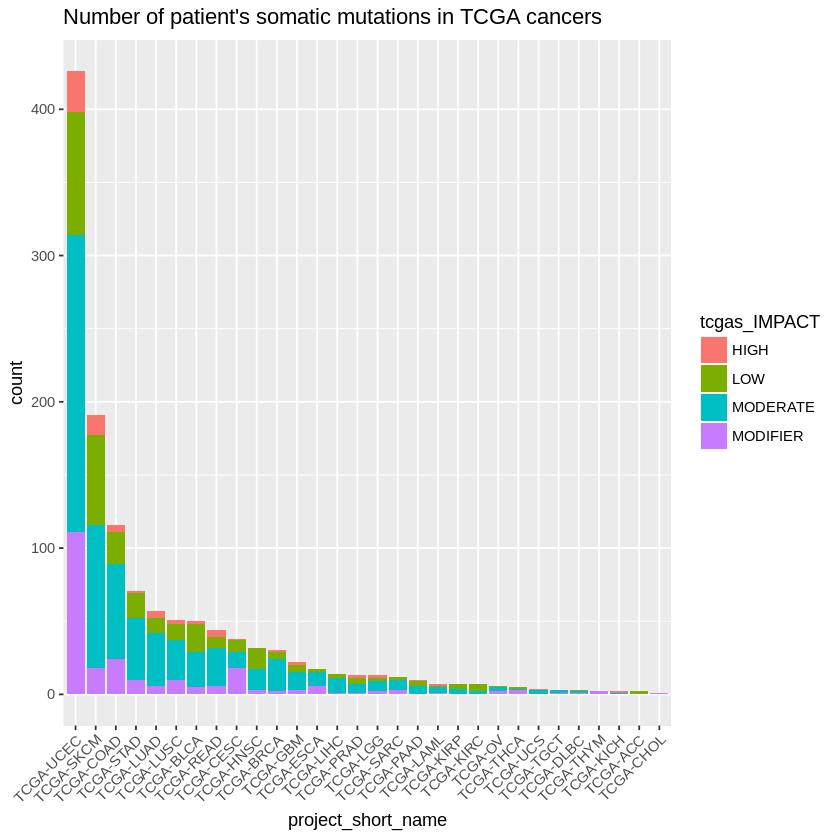

In [11]:
ggplot(common_snps, aes(project_short_name, fill=tcgas_IMPACT)) + geom_bar() + theme(axis.text.x=element_text(angle=45, hjust=1)) + labs(title="Number of patient's somatic mutations in TCGA cancers")

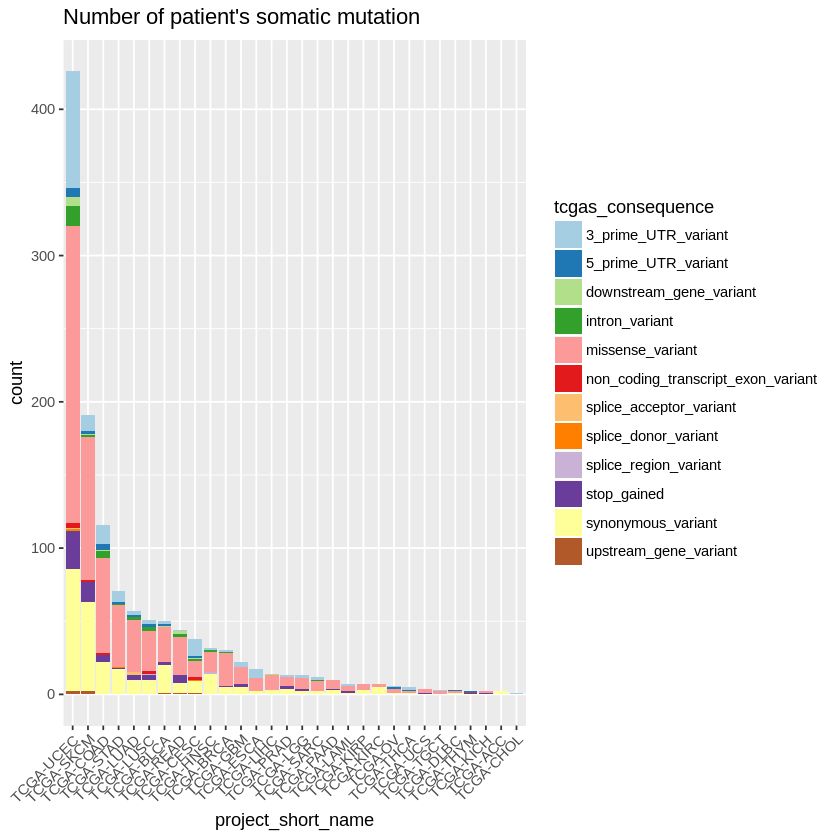

In [13]:
ggplot(common_snps, aes(project_short_name, fill=tcgas_consequence)) + geom_bar() + theme(axis.text.x=element_text(angle=45, hjust=1)) + labs(title="Number of patient's somatic mutation") + scale_fill_brewer(palette='Paired')

In [146]:
# -- Look for non-synonymous somatic mutations in patient's tumor that are in TCGA-KIRP
sql2 <- "SELECT tcgas.reference_allele, tcgas.tcgas.case_barcode, tcgas.symbol, tcgas.sample_barcode_tumor
FROM [p1rcc-coral:somatic.snvs_snpeff_pass_with_gene_ann] s
INNER JOIN [isb-cgc:TCGA_hg19_data_v0.Somatic_Mutation_MC3] tcgas on s.gene = tcgas.gene and s.end_position = tcgas.end_position
WHERE tcgas.variant_type = 'SNP' and tcgas.consequence <> 'synonymous_variant'  and tcgas.consequence <> 'synonymous_variant'    
AND tcgas.project_short_name = 'TCGA-KIRP'"
cases = query_exec(sql2, project = "p1rcc-coral", useLegacySql = FALSE)
head(cases)

0 bytes processed


tcgas_case_barcode,tcgas_symbol,tcgas_sample_barcode_tumor
TCGA-Y8-A8S0,DPP6,TCGA-Y8-A8S0-01A
TCGA-SX-A7SR,ST6GALNAC5,TCGA-SX-A7SR-01A
TCGA-AT-A5NU,AMPD2,TCGA-AT-A5NU-01A
TCGA-2Z-A9JD,FLG2,TCGA-2Z-A9JD-01A


In [148]:
# -- Look for effect of somatic mutations on gene expression in KIRP
sql <- "select * from [isb-cgc:TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM] ge
inner join [somatic.snps_x_tcgas] sxt on ge.original_gene_symbol = sxt.tcgas.hugo_symbol --and ge.case_barcode = sxt.tcgas.case_barcode
where ge.project_short_name = 'TCGA-KIRP'"
results <- query_exec(sql, project = "p1rcc-coral", useLegacySql = FALSE)
head(results)

0 bytes processed


ge_project_short_name,ge_case_barcode,ge_sample_barcode,ge_aliquot_barcode,ge_HGNC_gene_symbol,ge_gene_id,ge_normalized_count,ge_original_gene_symbol,ge_platform,sxt_s_reference_name,sxt_s_start_position,sxt_s_end_position,sxt_s_gene,sxt_tcgas_case_barcode,sxt_tcgas_hugo_symbol
TCGA-KIRP,TCGA-A4-7734,TCGA-A4-7734-01A,TCGA-A4-7734-01A-11R-A32Z-07,AMPD2,271,769.8203,AMPD2,IlluminaHiSeq,chr1,110170815,110170816,ENSG00000116337,TCGA-AT-A5NU,AMPD2
TCGA-KIRP,TCGA-BQ-7059,TCGA-BQ-7059-01A,TCGA-BQ-7059-01A-11R-1965-07,ST6GALNAC5,81849,174.3762,ST6GALNAC5,IlluminaHiSeq,chr1,77528709,77528710,ENSG00000117069,TCGA-SX-A7SR,ST6GALNAC5
TCGA-KIRP,TCGA-IA-A40U,TCGA-IA-A40U-01A,TCGA-IA-A40U-01A-11R-A24Z-07,DPP6,1804,0.0000,DPP6,IlluminaHiSeq,chr7,153750095,153750096,ENSG00000130226,TCGA-Y8-A8S0,DPP6
TCGA-KIRP,TCGA-A4-A4ZT,TCGA-A4-A4ZT-11A,TCGA-A4-A4ZT-11A-11R-A26U-07,FLG2,388698,6.8336,FLG2,IlluminaHiSeq,chr1,152324406,152324407,ENSG00000143520,TCGA-2Z-A9JD,FLG2
TCGA-KIRP,TCGA-4A-A93Y,TCGA-4A-A93Y-01A,TCGA-4A-A93Y-01A-11R-A37K-07,FLG2,388698,0.4662,FLG2,IlluminaHiSeq,chr1,152324406,152324407,ENSG00000143520,TCGA-2Z-A9JD,FLG2
TCGA-KIRP,TCGA-A4-7734,TCGA-A4-7734-01A,TCGA-A4-7734-01A-11R-A32Z-07,DPP6,1804,501.8499,DPP6,IlluminaHiSeq,chr7,153750095,153750096,ENSG00000130226,TCGA-Y8-A8S0,DPP6


In [147]:
# -- Look for mutated genes in KIRP and protein expression
sql_protein <- "select * from [isb-cgc:TCGA_hg19_data_v0.Protein_Expression] ge
inner join [somatic.snps_x_tcgas] sxt on ge.gene_name = sxt.tcgas.hugo_symbol --and ge.case_barcode = sxt.tcgas.case_barcode
where ge.project_short_name = 'TCGA-KIRP'"
proteins = query_exec(sql_protein, project = "p1rcc-coral", useLegacySql = FALSE)
head(proteins)

0 bytes processed


ge_project_short_name,ge_case_barcode,ge_sample_barcode,ge_aliquot_barcode,ge_gene_name,ge_protein_base_name,ge_phospho,ge_protein_name,ge_protein_expression,ge_antibody_source,ge_validation_status,sxt_s_reference_name,sxt_s_start_position,sxt_s_end_position,sxt_s_gene,sxt_tcgas_case_barcode,sxt_tcgas_hugo_symbol


In [120]:
results$type = sapply(strsplit(results$ge_sample_barcode, "-"), '[[', 4)
results$mut = 0
head(results)
results$mut[which(with(results, paste(ge_original_gene_symbol, ge_sample_barcode, sep=',')) %in% with(cases, paste(tcgas_symbol, tcgas_sample_barcode_tumor, sep=',')))]= 1
results = subset(results, type %in% c("01A","11A"))

ge_project_short_name,ge_case_barcode,ge_sample_barcode,ge_aliquot_barcode,ge_HGNC_gene_symbol,ge_gene_id,ge_normalized_count,ge_original_gene_symbol,ge_platform,sxt_s_reference_name,sxt_s_start_position,sxt_s_end_position,sxt_s_gene,sxt_tcgas_case_barcode,sxt_tcgas_hugo_symbol,type,mut
TCGA-KIRP,TCGA-A4-7734,TCGA-A4-7734-01A,TCGA-A4-7734-01A-11R-A32Z-07,AMPD2,271,769.8203,AMPD2,IlluminaHiSeq,chr1,110170815,110170816,ENSG00000116337,TCGA-AT-A5NU,AMPD2,01A,0
TCGA-KIRP,TCGA-BQ-7059,TCGA-BQ-7059-01A,TCGA-BQ-7059-01A-11R-1965-07,ST6GALNAC5,81849,174.3762,ST6GALNAC5,IlluminaHiSeq,chr1,77528709,77528710,ENSG00000117069,TCGA-SX-A7SR,ST6GALNAC5,01A,0
TCGA-KIRP,TCGA-IA-A40U,TCGA-IA-A40U-01A,TCGA-IA-A40U-01A-11R-A24Z-07,DPP6,1804,0.0000,DPP6,IlluminaHiSeq,chr7,153750095,153750096,ENSG00000130226,TCGA-Y8-A8S0,DPP6,01A,0
TCGA-KIRP,TCGA-A4-A4ZT,TCGA-A4-A4ZT-11A,TCGA-A4-A4ZT-11A-11R-A26U-07,FLG2,388698,6.8336,FLG2,IlluminaHiSeq,chr1,152324406,152324407,ENSG00000143520,TCGA-2Z-A9JD,FLG2,11A,0
TCGA-KIRP,TCGA-4A-A93Y,TCGA-4A-A93Y-01A,TCGA-4A-A93Y-01A-11R-A37K-07,FLG2,388698,0.4662,FLG2,IlluminaHiSeq,chr1,152324406,152324407,ENSG00000143520,TCGA-2Z-A9JD,FLG2,01A,0
TCGA-KIRP,TCGA-A4-7734,TCGA-A4-7734-01A,TCGA-A4-7734-01A-11R-A32Z-07,DPP6,1804,501.8499,DPP6,IlluminaHiSeq,chr7,153750095,153750096,ENSG00000130226,TCGA-Y8-A8S0,DPP6,01A,0


,ge_project_short_name,ge_case_barcode,ge_sample_barcode,ge_aliquot_barcode,ge_HGNC_gene_symbol,ge_gene_id,ge_normalized_count,ge_original_gene_symbol,ge_platform,sxt_s_reference_name,sxt_s_start_position,sxt_s_end_position,sxt_s_gene,sxt_tcgas_case_barcode,sxt_tcgas_hugo_symbol,type,mut
316,TCGA-KIRP,TCGA-SX-A7SR,TCGA-SX-A7SR-01A,TCGA-SX-A7SR-01A-12R-A36F-07,ST6GALNAC5,81849,27.2716,ST6GALNAC5,IlluminaHiSeq,chr1,77528709,77528710,ENSG00000117069,TCGA-SX-A7SR,ST6GALNAC5,01A,1
918,TCGA-KIRP,TCGA-Y8-A8S0,TCGA-Y8-A8S0-01A,TCGA-Y8-A8S0-01A-11R-A37K-07,DPP6,1804,0.0000,DPP6,IlluminaHiSeq,chr7,153750095,153750096,ENSG00000130226,TCGA-Y8-A8S0,DPP6,01A,1
1043,TCGA-KIRP,TCGA-2Z-A9JD,TCGA-2Z-A9JD-01A,TCGA-2Z-A9JD-01A-11R-A42S-07,FLG2,388698,0.5187,FLG2,IlluminaHiSeq,chr1,152324406,152324407,ENSG00000143520,TCGA-2Z-A9JD,FLG2,01A,1
1103,TCGA-KIRP,TCGA-AT-A5NU,TCGA-AT-A5NU-01A,TCGA-AT-A5NU-01A-11R-A28H-07,AMPD2,271,1054.9293,AMPD2,IlluminaHiSeq,chr1,110170815,110170816,ENSG00000116337,TCGA-AT-A5NU,AMPD2,01A,1


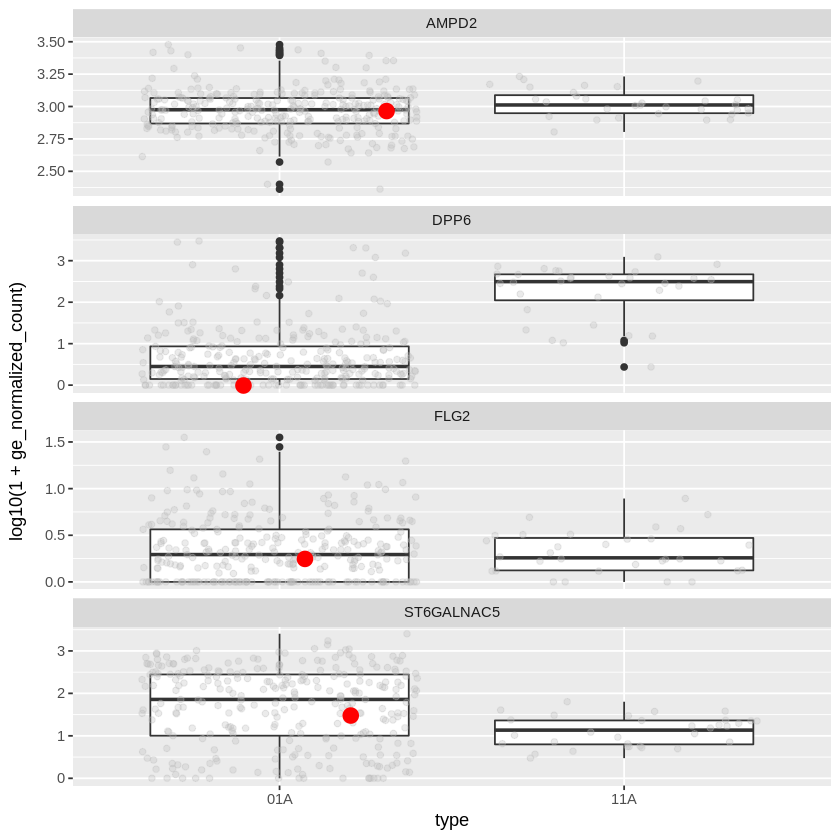

In [121]:
ggplot(results, aes(type, log10(1+ge_normalized_count))) + geom_boxplot() + geom_jitter(color='grey', alpha=0.3) + geom_jitter(data=subset(results, mut==1),color='red', size=4) + facet_wrap(~ge_original_gene_symbol, ncol=1, scale='free_y') + scale_color_manual(values=c("grey", "red"))

In [12]:
library(purrr)

In [46]:
snvs <- dplyr::tbl(con, "snvs") %>% 
    #select(filter) %>% 
    filter(reference_name != 'chr3' & start_position != 189918603 & end_position != 189918604) %>%
    head(20) %>%
    mutate(tmp = unlist(filter)) %>%
    data.frame()

ERROR: Error: Function not found: UNLIST at [1:277] [invalidQuery]


In [40]:
str(snvs)

'data.frame':	20 obs. of  24 variables:
 $ reference_name : chr  "chr11" "chr11" "chr11" "chr11" ...
 $ start_position : int  108879205 109712482 129212992 133511628 133513544 114424808 121859310 124783059 128043291 117894226 ...
 $ end_position   : int  108879206 109712483 129212993 133511629 133513545 114424809 121859311 124783060 128043292 117894227 ...
 $ reference_bases: chr  "A" "A" "A" "A" ...
 $ alternate_bases:List of 20
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  

'data.frame':	20 obs. of  24 variables:
 $ reference_name : chr  "chr20" "chr20" "chr20" "chr20" ...
 $ start_position : int  60207905 61617893 62308158 62324868 10024053 10087501 10727935 10768697 10790224 52470213 ...
 $ end_position   : int  60207906 61617894 62308159 62324869 10024054 10087502 10727936 10768698 10790225 52470214 ...
 $ reference_bases: chr  "A" "A" "A" "A" ...
 $ alternate_bases:List of 20
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "C"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "T"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "A"
  ..$ :Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  1 variable:
  .. ..$ alt: chr "G"
  ..$ :Classes ‘tbl_df

In [32]:
library(DBI)

In [34]:
list

ERROR: Error in as.sql(from): argument "from" is missing, with no default


In [70]:
source("https://bioconductor.org/biocLite.R")
biocLite("VariantAnnotation")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.1 (2017-06-30).
Installing package(s) ‘VariantAnnotation’
also installing the dependencies ‘RMySQL’, ‘GenomicFeatures’

Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘RMySQL’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘GenomicFeatures’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘VariantAnnotation’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'bindrcpp', 'bit', 'bit64', 'config', 'dplyr', 'forecast',
  'foreign', 'hms', 'htmlwidgets', 'httpuv',

In [72]:
library(VariantAnnotation)

ERROR: Error in library(VariantAnnotation): there is no package called ‘VariantAnnotation’
